# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [92]:
#!pip install -U fsds_100719

In [93]:
from fsds_100719.imports import *

pd.set_option('display.max_columns',0)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-notebook')


In [94]:
#df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-online-ds-ft-10072019/master/zillow_data.csv')
df = pd.read_csv('zillow_data.csv')
df.head().style.set_caption("Original Wide Format")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200,335400,336500,337600,338500,339500,340400,341300,342600,344400,345700,346700,347800,349000,350400,352000,353900,356200,358800,361800,365700,370200,374700,378900,383500,388300,393300,398500,403800,409100,414600,420100,426200,432600,438600,444200,450000,455900,462100,468500,475300,482500,490200,498200,507200,516800,526300,535300,544500,553500,562400,571200,579800,588100,596300,604200,612200,620200,627700,634500,641000,647000,652700,658100,663300,668400,673400,678300,683200,688300,693300,698000,702400,706400,710200,714000,717800,721700,725700,729900,733400,735600,737200,739000,740900,742700,744400,746000,747200,748000,749000,750200,752300,755300,759200,764000,769600,775600,781900,787900,793200,798200,803100,807900,812900,818100,823100,828300,834100,839800,845600,851800,858000,864400,870700,876200,880700,884400,887600,890500,893300,895500,897300,899000,900400,902000,904400,907100,909700,911900,913000,913000,912000,909300,905300,901400,897900,895400,893600,891100,887000,881700,875900,870300,865100,859000,851500,843800,836400,830700,827300,824800,821600,818300,814600,809800,803600,795500,786900,780700,776900,774700,774200,774400,774600,775600,777800,775200,767900,764700,766100,764100,759700,754900,746200,737300,730800,729300,730200,730700,730000,730100,730100,731200,733900,735500,735400,734400,737500,737700,733700,734000,740300,744600,750500,760400,771800,780600,787900,794100,798900,802300,806100,810900,817400,826800,837900,848100,853800,856700,856600,854400,853000,856200,859700,863900,872900,883300,889500,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,9991

In [95]:
import functions_mod4proj as ji
help(ji)

Help on module functions_mod4proj:

NAME
    functions_mod4proj

FUNCTIONS
    get_model_metrics(true, preds, train, explain_U=False)
    
    get_train_test_split_index(ts, TEST_SIZE=0.2)
    
    make_dateindex(df_to_add_index, index_col='Month', index_name='date', drop=True, freq=None, verbose=True)
    
    melt_data(df)
    
    meta_grid_search(ts, TEST_SIZE=0.2, model_kws={}, verbose=True, return_kws=False)
    
    plotly_timeseries(df, x='datetime', y='MeanValue', color='RegionID', line_group='State')
    
    stationarity_check(TS, plot=True, col=None)
        From: https://learn.co/tracks/data-science-career-v2/module-4-a-complete-data-science-project-using-multiple-regression/working-with-time-series-data/time-series-decomposition
    
    thiels_U(ys_true=None, ys_pred=None, display_equation=True, display_table=True)
        Calculate's Thiel's U metric for forecasting accuracy.
        Accepts true values and predicted values.
        Returns Thiel's U

FILE
    c:\users\

In [96]:
def melt_data(df):
    melted = pd.melt(df, id_vars = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
                                    'SizeRank'],var_name = 'Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    melted = melted.dropna(subset = ['MeanValue'])
    return melted



In [97]:
df = melt_data(df)
df.head().style.set_caption("MELTED LONG FORMAT")

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01 00:00:00,334200
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01 00:00:00,235700
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01 00:00:00,210400
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01 00:00:00,498100
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01 00:00:00,77300


# Step 2: Data Preprocessing

In [98]:
def make_dateindex(df, index_col='Month', drop = False, verbose = True):

    
    # Make datetime column which will become the index
    df[index_col] = pd.to_datetime(df[index_col], errors = 'coerce')
    
    
    # assign index
    df = df.set_index('Month', drop = drop)
    
    # Ask about what this means
    
    if verbose:
        display(df.index)
    return df

df = make_dateindex(df)
df

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=3744704, freq=None)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Month,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
1996-04-01,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0


In [99]:
df = df.rename(columns = {'Month':'Date',})
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
1996-04-01,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
1996-04-01,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
1996-04-01,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0


In [100]:
# Select the counties in California, where most people move to from San Francisco
df_sf_county = df.loc[df['CountyName'] == 'San Francisco']
len(df_sf_county)

5035

In [101]:
df_sf_county.head()
    
    

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,MeanValue
Month,,,,,,,,,
1996-04-01,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0
1996-04-01,97565,94110,San Francisco,CA,San Francisco,San Francisco,77,1996-04-01,213900.0
1996-04-01,97576,94122,San Francisco,CA,San Francisco,San Francisco,334,1996-04-01,278400.0
1996-04-01,97567,94112,San Francisco,CA,San Francisco,San Francisco,505,1996-04-01,210100.0
1996-04-01,97569,94115,San Francisco,CA,San Francisco,San Francisco,743,1996-04-01,794000.0


In [102]:
df_sf_county.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
Date          0
MeanValue     0
dtype: int64

In [103]:
df_sf_county['RegionName'].nunique()

19

In [104]:
sf_city = {}
for zipcode in df_sf_county['RegionName'].unique():
    temp = df_sf_county.groupby('RegionName').get_group(zipcode)
    sf_city[zipcode] = temp.resample('MS').asfreq()

sf_city




{94109:             RegionID  RegionName    ...           Date  MeanValue
 Month                               ...                          
 1996-04-01     97564       94109    ...     1996-04-01   766000.0
 1996-05-01     97564       94109    ...     1996-05-01   771100.0
 1996-06-01     97564       94109    ...     1996-06-01   776500.0
 1996-07-01     97564       94109    ...     1996-07-01   781900.0
 1996-08-01     97564       94109    ...     1996-08-01   787300.0
 1996-09-01     97564       94109    ...     1996-09-01   793000.0
 1996-10-01     97564       94109    ...     1996-10-01   799100.0
 1996-11-01     97564       94109    ...     1996-11-01   805800.0
 1996-12-01     97564       94109    ...     1996-12-01   814400.0
 1997-01-01     97564       94109    ...     1997-01-01   824300.0
 1997-02-01     97564       94109    ...     1997-02-01   833800.0
 1997-03-01     97564       94109    ...     1997-03-01   842900.0
 1997-04-01     97564       94109    ...     1997-04-01

# Step 3: EDA and Visualization

[94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114, 94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124, 94127]


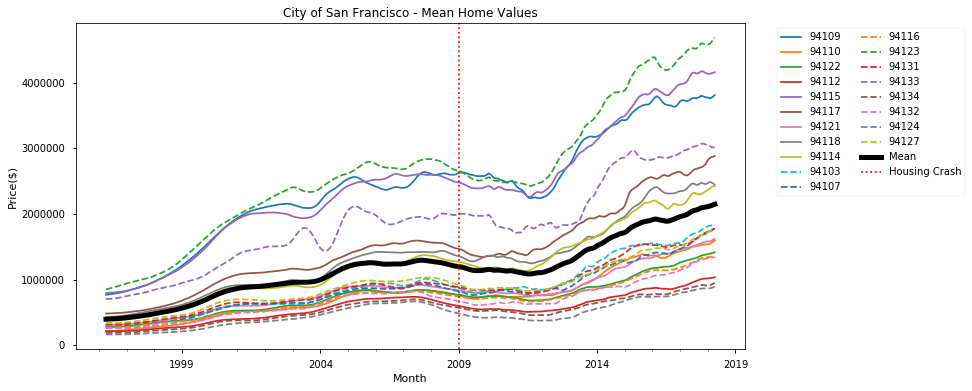

In [171]:
def plot_value(df_dict, col = 'MeanValue', zipcodes = []):
    '''This function takes in a dictionary and plots a list of values
       
       df_dict is the timeseries data in dictionary form
       col is the column to be plotted, default is a column called "MeanValue"
       zipcodes are the list of timeseries to be plotted '''
       
    if len(zipcodes) == 0:
        zipcodes = list(df_dict.keys())
        
        print(zipcodes)
        
        cutoff = len(zipcodes)//2
        
        fig,ax = plt.subplots(figsize = (12,6))
        
        ts_dict = {}
        for i,zc in enumerate(zipcodes):
            if i < cutoff:
                ls = '-'
            else:
                ls = '--'
                
            ts = df_dict[zc][col].rename(zc)
            ts.plot(label = str(zc), ax = ax, ls = ls)
            ts_dict[zc] = ts
            
        mean = pd.DataFrame(ts_dict).mean(axis = 1)
        mean.plot(label = 'Mean', lw = 5, color = 'black')
        
        crash = '01-2009'
        ax.axvline(crash, label = 'Housing Crash', color = 'red',ls = ':')
        
        ax.legend(bbox_to_anchor = (1.04, 1), loc = 'upper left', ncol = 2)
        ax.set(title = 'City of San Francisco - Mean Home Values', ylabel = 'Price($)')
        
        return fig,ax, ts_dict
fig, ax, ts_dict = plot_value(sf_city)

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot


In [107]:
def plot_acf_pacf(ts, figsize = (10,8), lags = 20):
    '''The purpose of this function is to plot the ACF (Akaike Correlation Function)
    and the PACF Partial autocorrelation function from the timeseries dataframe'''
    
    
    fig,ax = plt.subplots(nrows = 3, figsize = figsize)
    ts.plot(ax=ax[0])
    plot_acf(ts, ax=ax[1], lags = lags)
    plot_pacf(ts, ax=ax[2], lags = lags)
    plt.tight_layout()
    
    plt.suptitle(f'Zipcode: {ts.name}', y=1.1, fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks = lags, integer = True))
        a.xaxis.grid()
              

In [108]:
zips = list(ts_dict.keys())
zips

[94109,
 94110,
 94122,
 94112,
 94115,
 94117,
 94121,
 94118,
 94114,
 94103,
 94107,
 94116,
 94123,
 94131,
 94133,
 94134,
 94132,
 94124,
 94127]

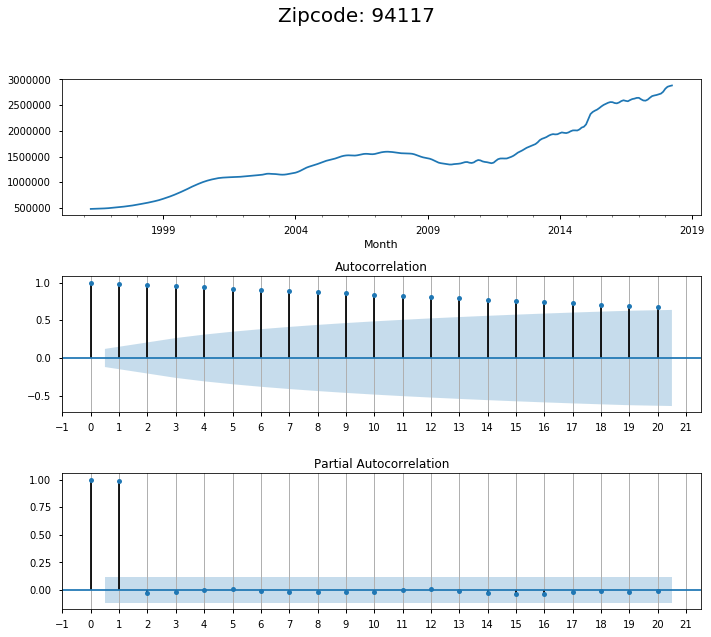

In [109]:
ts = ts_dict[np.random.choice(zips)]
plot_acf_pacf(ts)

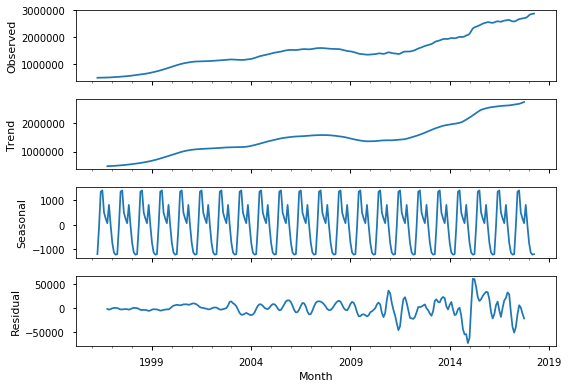

In [110]:
plt.style.use('seaborn-notebook')

seasonality = seasonal_decompose(ts)
seasonality.plot();
plt.tight_layout()

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

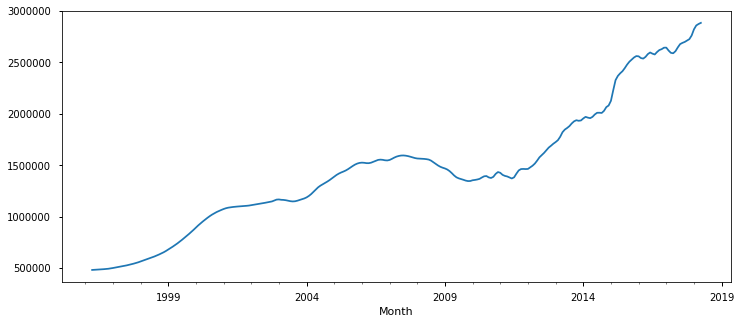

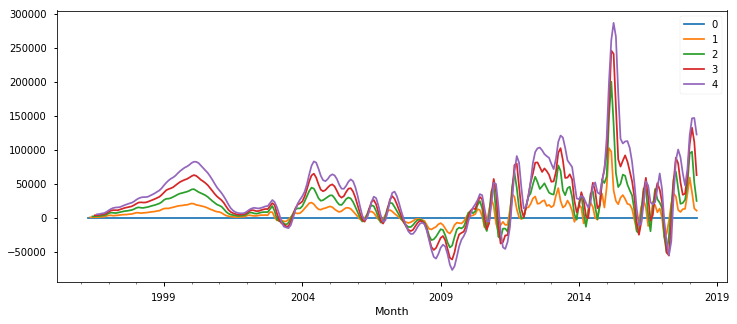

In [114]:
mpl.rcParams['figure.figsize'] = (12,5)
ts.plot()
plt.figure();
for i in range(5):
    ax = ts.diff(i).plot(label = i)
ax.legend();


In [127]:
def opt_pdq_pdqm(ps = [0,1,3], ds = [0,1,2,3], qs=[0,1,3], make_seasonal=True, m_values=[12]):
    import itertools
    
    params = {}
    params['pdq'] = list(itertools.product(ps, ds, qs, m_values))
    
    if make_seasonal:
        params['PDQM'] = list(itertools.product(ps,ds,qs,m_values))
    return params

def get_train_test_split_index(ts, TEST_SIZE= 0.1, min_test_ts = 2):
    import math
    idx_split = math.floor(len(ts.index) * (1 - TEST_SIZE))
    
    num_test_ts = len(ts.iloc[idx_split:])
    if num_test_ts < min_test_ts:
        print(f'Using TEST_SIZE produced {num_test_ts} test timestamps')
        print(f' - override TEST_SIZE and use min_test_ts instead')
        
        idx_split = len(ts) - min_test_ts
        
    return idx_split

def train_test_split_ts(ts, test_size = 0.2, min_test_ts = 2):
    idx_split = get_train_test_split_index(ts, TEST_SIZE = test_size,
                                          min_test_ts = min_test_ts)
    ts_train = ts.iloc[:idx_split]
    ts_test = ts.iloc[idx_split:]
    return ts_train, ts_test

def get_time(return_dt = True, return_str = True, show = False):
    import datetime as dt
    import tzlocal as tz
    now = dt.datetime.now(tz=tz.get_localzone())
    str_time = now.strftime('%m/%d/%Y - %I:%M:%S %p')
    if show:
        print(str_time)
        
    output = []
    if return_dt:
        output.append(now)
        
    if return_str:
        output.append(str_time)
        
        return output[:]
    
    
    
    
    

In [128]:
params = opt_pdq_pdqm()
print(params.keys())
print(params['pdq'][:10])
params['PDQM'][:10]

dict_keys(['pdq', 'PDQM'])
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 3, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 3, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 3, 12), (0, 3, 0, 12)]


[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 3, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 3, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 3, 12),
 (0, 3, 0, 12)]

In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def grid_search_arima(ts_train, pdq = None, pdqm = None, order_dict = None, 
                   make_seasonal = False, verbose = False, model_kws={}):
    
    from tqdm import trange
    
    if (pdq is None) & (order_dict is not None):
        pdq = order_dict['pdq']
        
    if (pdqm is None) & (order_dict is not None):
        pdqm = order_dict['PDQM']
        
        
        start, start_str = get_time(return_dt = True, return_str = True)
        print(f'[i] Starting Grid Search @ {start_str}:')
        
        res = [['pdq', 'PDQM', 'AIC']]
        for i in trange((len(pdq))):
            comb = pdq[i]
            
            if make_seasonal:
                for combs in pdqm:
                    try: 
                        model = SARIMAX(ts_train, order = comb, 
                                       seasonal_order = combs, enforce_stationarity = False,
                                       enforce_invertibility = False, **model_kws)
                        output = model.fit()
                        res.append([comb, combs, output.aic])
                    except:
                        if verbose:
                            print(f'Error running ({comb})({combs})')
                        continue

            if make_seasonal == False:
                    try:
                        model = SARIMAX(ts_train, order = comb, enforce_stationarity = False,
                                   enforce_invertibility = False, **model_kws)

                        output = model.fit()
                        res.append([comb, 'N/A', output.aic])

                    except:
                        if verbose:
                            print(f' Error running ({comb} / {combs})')
                            continue

    end, end_str = get_time(return_dt = True, return_str = True)
    elapsed = end-start
    print(f' Grid Search finished at {end_str}')
    print(f' Total time: {elapsed}')
          
    try:
          df_res = fs.list2df(res)
          return df_res
          
    except:
          print(' Error converting to DF,  returning list')
          return res


In [139]:
ts = ts_dict[94123]
ts_train, ts_test = train_test_split_ts(ts, test_size =0.1)

len(ts_train), len(ts_test)


(238, 27)

In [140]:
res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
res.sort_values('AIC', inplace=True)
res.head()

[i] Starting Grid Search @ 01/10/2020 - 09:23:56 PM:


100%|██████████| 36/36 [00:05<00:00,  3.74it/s]


 Grid Search finished at 01/10/2020 - 09:24:02 PM
 Total time: 0:00:05.761585


,pdq,PDQM,AIC
32,"(3, 2, 3, 12)",N/A,4767.698737
20,"(1, 2, 3, 12)",N/A,4781.219571
8,"(0, 2, 3, 12)",N/A,4782.024671
35,"(3, 3, 3, 12)",N/A,4791.148052
29,"(3, 1, 3, 12)",N/A,4792.339155


# Step 6: Interpreting Results

In [141]:
best_params = dict(order=res.iloc[0].loc['pdq'])
best_params

{'order': (3, 2, 3, 12)}

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  94123   No. Observations:                  238
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -2376.849
Date:                Fri, 10 Jan 2020   AIC                           4767.699
Time:                        21:29:21   BIC                           4791.826
Sample:                    04-01-1996   HQIC                          4777.429
                         - 01-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0832      0.227      0.366      0.714      -0.362       0.528
ar.L2         -0.5329      0.072     -7.412      0.000      -0.674      -0.392
ar.L3          0.2038      0.098      2.073      0.038       0.011       0.397
ma.L1          0.6020      0.236      2.545      0.011       0.138       1.066
ma.L2          0.2569      0.222      1.157      0.247      -0.178       0.692
ma.L3          0.0537      0.081      0.664      0.506      -0.105       0.212
sigma2      4.299e+07   2.06e-08   2.08e+15      0.000     4.3e+07     4.3e+07
===================================================================================
Ljung-Box (Q):                      146.86   Jarque-Bera (JB):               290.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              41.07   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.87e+30. Standard errors may be unstable.
"""

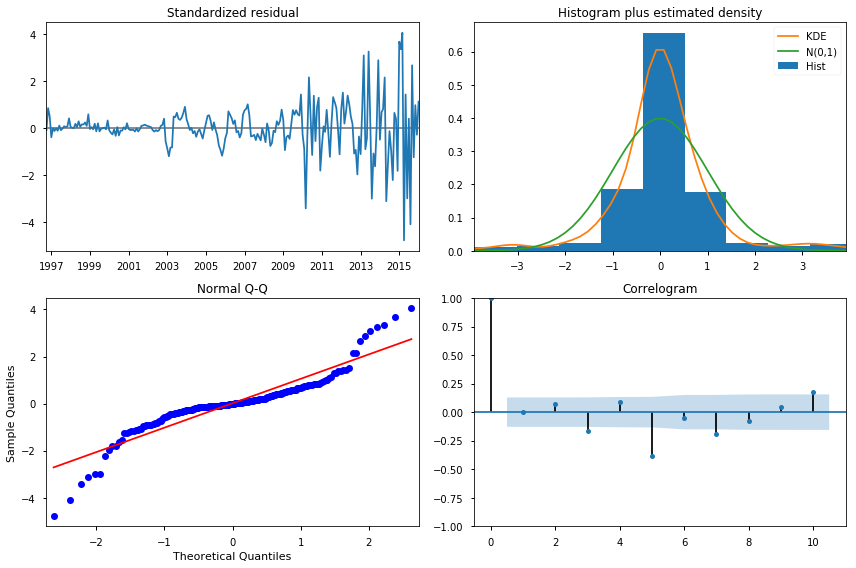

In [145]:
model_output = SARIMAX(ts_train, **best_params,
                      enforce_invertibility=False, 
                      enforce_stationarity=False).fit()
display(model_output.summary())
model_output.plot_diagnostics(figsize=(12,8));
plt.tight_layout()

# Model Evaluation Functions


In [156]:
def model_evaluation(ts_true, ts_pred, show=True, show_u_info=False):
    '''Evaluate the model with RMSE, R2, and Thiels U metrics and prints a pretty dataframe'''
    from sklearn.metrics import mean_squared_error, r2_score
    
    res = [['Metric','Value']]
    
    res.append(['RMSE', np.sqrt(mean_squared_error(ts_true, ts_pred))])
    res.append(['R2', r2_score(ts_true, ts_pred)])
    res.append(["Thiel's U", fs.jmi.thiels_U(ts_true, ts_pred,
              display_equation=show_u_info, 
              display_table = show_u_info)])
    res = fs.list2df(res)
    
    if show:
        display(res)
    return res

def expected_roi(investment, final_value):
    roi = np.round(((final_value - investment) / investment) *100, 3)
    return roi

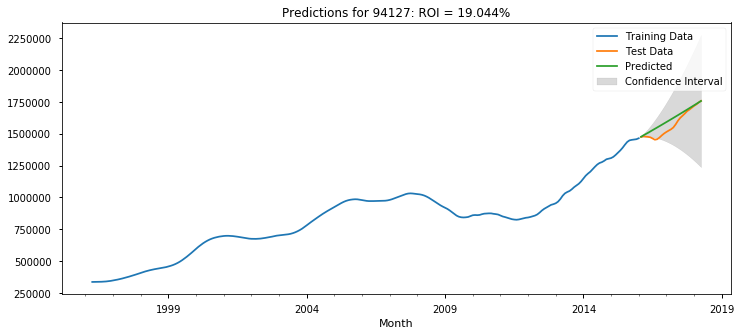

,Metric,Value
0,RMSE,53398.755293
1,R2,0.730304
2,Thiel's U,3.986146


,lower 94127,upper 94127,predicted_mean
2016-02-01,1.472679e+06,1.480125e+06,1.476402e+06
2016-03-01,1.476228e+06,1.498962e+06,1.487595e+06
2016-04-01,1.476481e+06,1.518403e+06,1.497442e+06
2016-05-01,1.475974e+06,1.538640e+06,1.507307e+06
2016-06-01,1.475188e+06,1.560506e+06,1.517847e+06
2016-07-01,1.473243e+06,1.583847e+06,1.528545e+06
2016-08-01,1.469832e+06,1.608216e+06,1.539024e+06
2016-09-01,1.465364e+06,1.633538e+06,1.549451e+06
2016-10-01,1.460130e+06,1.659912e+06,1.560021e+06
2016-11-01,1.454069e+06,1.687310e+06,1.570689e+06


In [173]:
def get_model_preds_df(model_output, ts_train, ts_test, start=None, end=None, get_metrics = True):
    
    if start is None:
        start = ts_test.index[0]
        
    if end is None:
        end = ts_test.index[-1]
        
    prediction = model_output.get_prediction(start=start, end=end, dynamic=True)
    
    preds_df = prediction.conf_int()
    preds_df['predicted_mean'] = prediction.predicted_mean
    plot_df = pd.concat([preds_df, ts_train], axis=1)
    
    roi = expected_roi(preds_df['predicted_mean'].iloc[0], preds_df['predicted_mean'].iloc[-1])
    
    zc = ts_train.name
    
    fig, ax = plt.subplots()
    ts_train.plot(ax=ax, label= 'Training Data')
    ts_test.plot(ax=ax, label='Test Data')
    
    #preds_df['predicted_mean'].plot(ax=ax)
    
    ax.fill_between(preds_df.index, preds_df[f'lower {zc}'],
                   preds_df[f'upper {zc}'], color="k", alpha=0.15,
                    label = 'Confidence Interval')
    
    prediction.predicted_mean.plot(ax=ax, label='Predicted')
    
    ax.legend()
    
    ax.set(title=f"Predictions for {zc}: ROI = {roi}%")
    
    fig = ax.get_figure()
    
    plot_df['zipcode'] = ts_train.name
    plt.show()
    
    if get_metrics:
        res = model_evaluation(ts_test, preds_df["predicted_mean"])
    return preds_df, fig,ax

preds_df, fig,ax = get_model_preds_df(model_output, ts_train, ts_test)
preds_df

# Grid Search for all zipcodes in the county


[94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114, 94103, 94107, 94116, 94123, 94131, 94133, 94134, 94132, 94124, 94127]


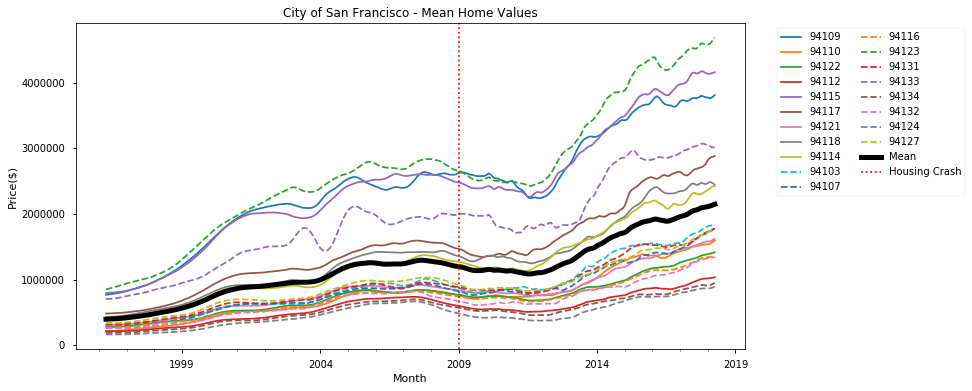

In [161]:
fig,ax,ts_dict = plot_value(sf_city)

In [162]:
print(ts.index[0])
ts.index[0] + pd.to_timedelta(1,'MS')
end=ts.index[0] + pd.to_timedelta(1,'MS')
pd.to_datetime(end)

1996-04-01 00:00:00


Timestamp('1996-04-01 00:00:00.001000', freq='MS')



------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94109
[i] Starting Grid Search @ 01/10/2020 - 11:12:43 PM:


100%|██████████| 36/36 [00:09<00:00,  2.22it/s]


 Grid Search finished at 01/10/2020 - 11:12:53 PM
 Total time: 0:00:09.944672
Best Params {'order': (3, 2, 3, 12)}


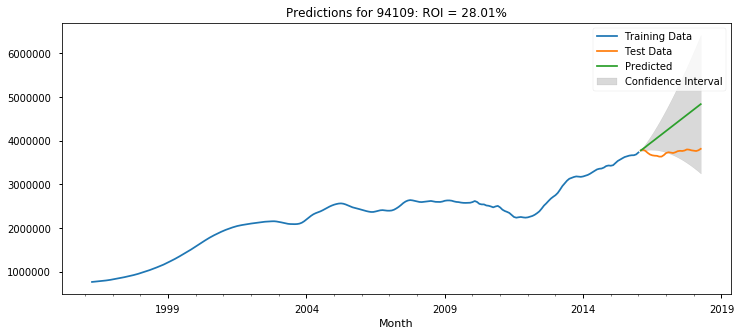

,Metric,Value
0,RMSE,641154.543431
1,R2,-146.159924
2,Thiel's U,29.384832




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94110
[i] Starting Grid Search @ 01/10/2020 - 11:12:54 PM:


100%|██████████| 36/36 [00:07<00:00,  2.61it/s]


 Grid Search finished at 01/10/2020 - 11:13:01 PM
 Total time: 0:00:07.283824
Best Params {'order': (3, 3, 3, 12)}


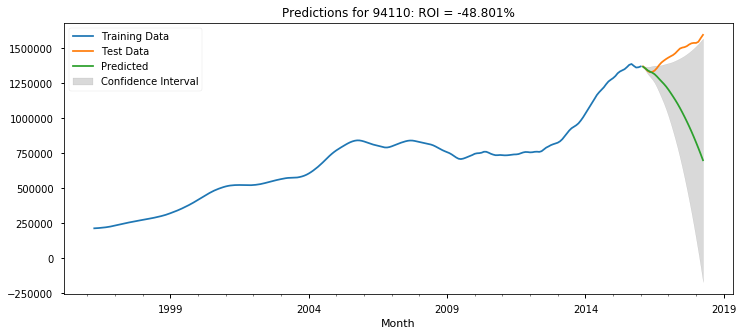

,Metric,Value
0,RMSE,440406.241050
1,R2,-28.971474
2,Thiel's U,31.375860




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94122
[i] Starting Grid Search @ 01/10/2020 - 11:13:02 PM:


100%|██████████| 36/36 [00:08<00:00,  2.84it/s]


 Grid Search finished at 01/10/2020 - 11:13:11 PM
 Total time: 0:00:08.717350
Best Params {'order': (3, 1, 3, 12)}


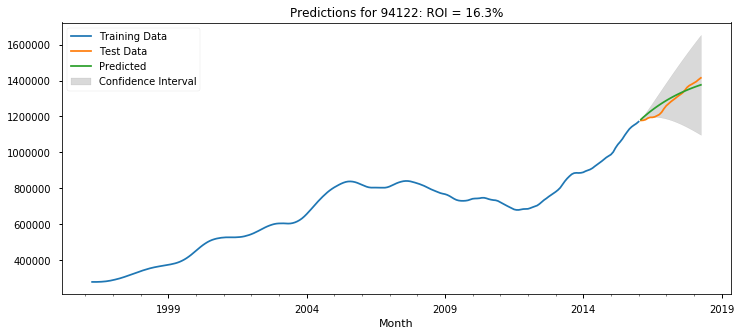

,Metric,Value
0,RMSE,29631.528315
1,R2,0.859072
2,Thiel's U,3.060886




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94112
[i] Starting Grid Search @ 01/10/2020 - 11:13:12 PM:


100%|██████████| 36/36 [00:07<00:00,  3.85it/s]


 Grid Search finished at 01/10/2020 - 11:13:20 PM
 Total time: 0:00:08.000463
Best Params {'order': (3, 2, 0, 12)}


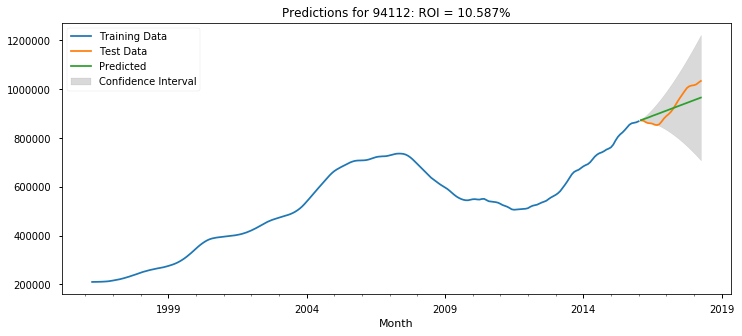

,Metric,Value
0,RMSE,41122.307280
1,R2,0.605597
2,Thiel's U,4.427635




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94115
[i] Starting Grid Search @ 01/10/2020 - 11:13:20 PM:


100%|██████████| 36/36 [00:05<00:00,  3.51it/s]


 Grid Search finished at 01/10/2020 - 11:13:26 PM
 Total time: 0:00:06.013908
Best Params {'order': (3, 2, 3, 12)}


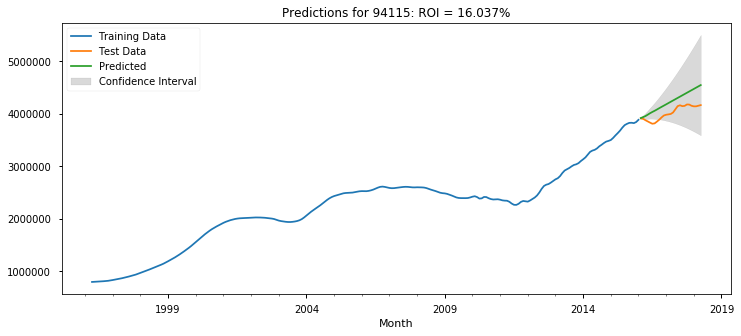

,Metric,Value
0,RMSE,230126.853392
1,R2,-2.105698
2,Thiel's U,8.612528




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94117
[i] Starting Grid Search @ 01/10/2020 - 11:13:27 PM:


100%|██████████| 36/36 [00:06<00:00,  2.67it/s]


 Grid Search finished at 01/10/2020 - 11:13:33 PM
 Total time: 0:00:06.105663
Best Params {'order': (3, 2, 3, 12)}


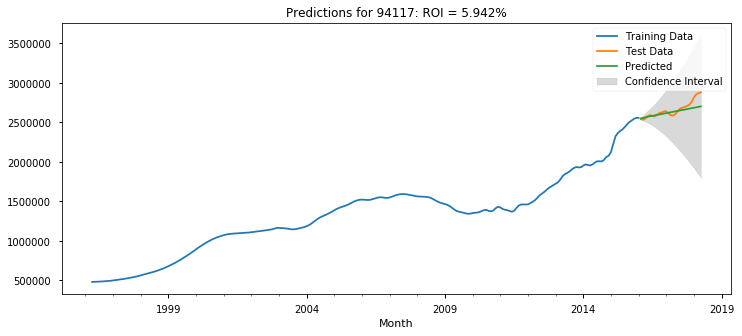

,Metric,Value
0,RMSE,68670.782454
1,R2,0.520162
2,Thiel's U,2.883054




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94121
[i] Starting Grid Search @ 01/10/2020 - 11:13:34 PM:


100%|██████████| 36/36 [00:05<00:00,  3.57it/s]


 Grid Search finished at 01/10/2020 - 11:13:39 PM
 Total time: 0:00:05.601013
Best Params {'order': (3, 3, 3, 12)}


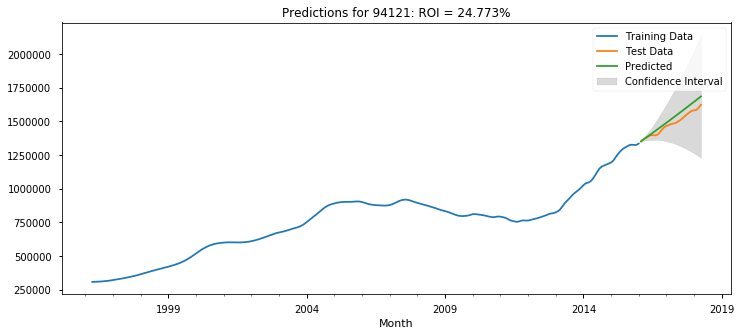

,Metric,Value
0,RMSE,43925.281864
1,R2,0.691414
2,Thiel's U,3.606351




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94118
[i] Starting Grid Search @ 01/10/2020 - 11:13:40 PM:


100%|██████████| 36/36 [00:08<00:00,  2.26it/s]


 Grid Search finished at 01/10/2020 - 11:13:48 PM
 Total time: 0:00:08.022542
Best Params {'order': (3, 1, 3, 12)}


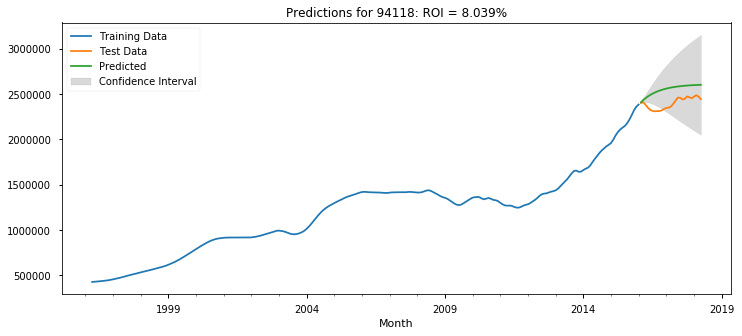

,Metric,Value
0,RMSE,162532.746786
1,R2,-6.076553
2,Thiel's U,8.898741




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94114
[i] Starting Grid Search @ 01/10/2020 - 11:13:49 PM:


100%|██████████| 36/36 [00:07<00:00,  3.19it/s]


 Grid Search finished at 01/10/2020 - 11:13:57 PM
 Total time: 0:00:07.797378
Best Params {'order': (3, 2, 3, 12)}


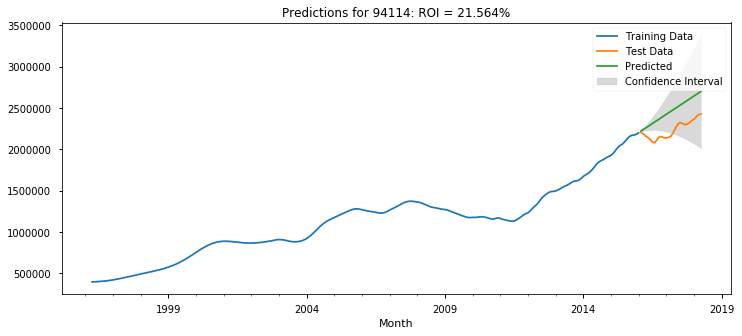

,Metric,Value
0,RMSE,239890.201499
1,R2,-4.239685
2,Thiel's U,9.415467




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94103
[i] Starting Grid Search @ 01/10/2020 - 11:13:58 PM:


100%|██████████| 36/36 [00:06<00:00,  2.43it/s]


 Grid Search finished at 01/10/2020 - 11:14:04 PM
 Total time: 0:00:06.092697
Best Params {'order': (3, 3, 3, 12)}


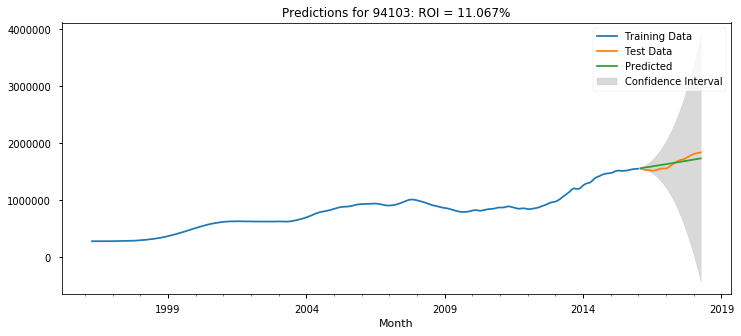

,Metric,Value
0,RMSE,64822.343604
1,R2,0.665238
2,Thiel's U,4.002245




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94107
[i] Starting Grid Search @ 01/10/2020 - 11:14:05 PM:


100%|██████████| 36/36 [00:06<00:00,  3.51it/s]


 Grid Search finished at 01/10/2020 - 11:14:11 PM
 Total time: 0:00:06.563659
Best Params {'order': (3, 2, 3, 12)}


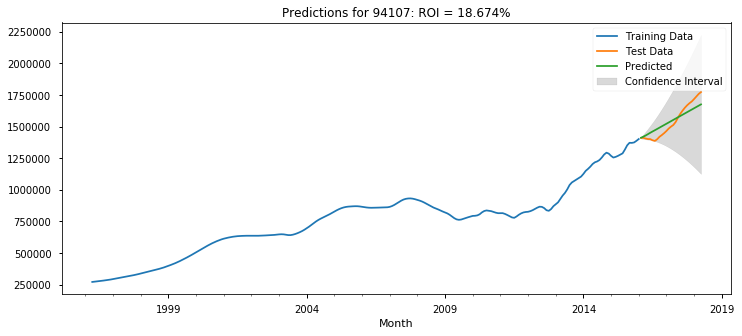

,Metric,Value
0,RMSE,58246.058333
1,R2,0.800766
2,Thiel's U,3.381108




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94116
[i] Starting Grid Search @ 01/10/2020 - 11:14:12 PM:


100%|██████████| 36/36 [00:08<00:00,  1.52it/s]


 Grid Search finished at 01/10/2020 - 11:14:21 PM
 Total time: 0:00:08.788023
Best Params {'order': (3, 2, 3, 12)}


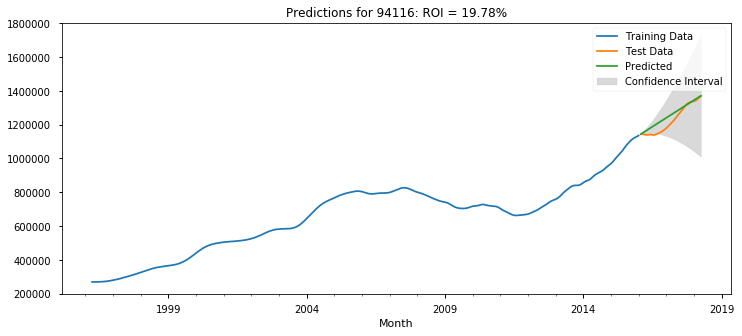

,Metric,Value
0,RMSE,37978.083292
1,R2,0.788484
2,Thiel's U,3.798098




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94123
[i] Starting Grid Search @ 01/10/2020 - 11:14:23 PM:


100%|██████████| 36/36 [7:42:33<00:00, 83.76s/it]     


 Grid Search finished at 01/11/2020 - 06:56:57 AM
 Total time: 7:42:33.583910
Best Params {'order': (3, 2, 3, 12)}


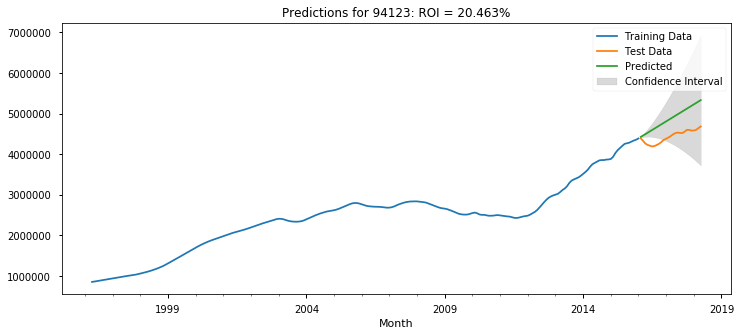

,Metric,Value
0,RMSE,471138.286046
1,R2,-8.503554
2,Thiel's U,14.050963




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94131
[i] Starting Grid Search @ 01/11/2020 - 06:56:59 AM:


100%|██████████| 36/36 [00:09<00:00,  2.44it/s]


 Grid Search finished at 01/11/2020 - 06:57:08 AM
 Total time: 0:00:09.385887
Best Params {'order': (3, 2, 3, 12)}


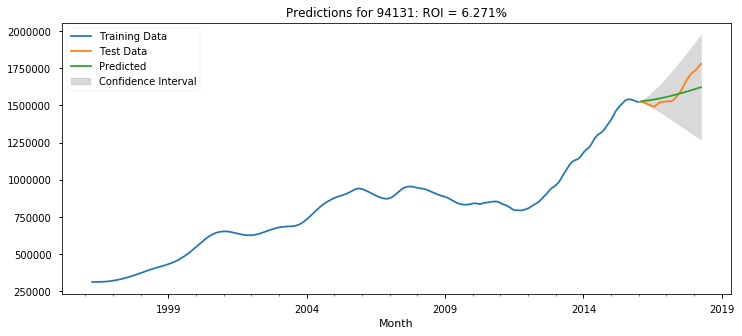

,Metric,Value
0,RMSE,68213.842414
1,R2,0.456749
2,Thiel's U,4.412808




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94133
[i] Starting Grid Search @ 01/11/2020 - 06:57:09 AM:


100%|██████████| 36/36 [00:08<00:00,  2.22it/s]


 Grid Search finished at 01/11/2020 - 06:57:17 AM
 Total time: 0:00:08.267876
Best Params {'order': (3, 1, 3, 12)}


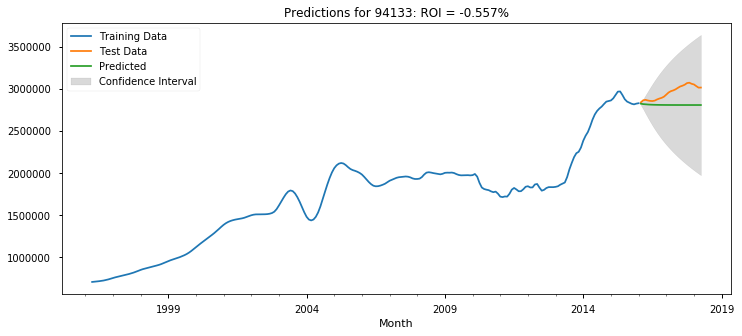

,Metric,Value
0,RMSE,168895.861656
1,R2,-3.485819
2,Thiel's U,11.963175




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94134
[i] Starting Grid Search @ 01/11/2020 - 06:57:18 AM:


100%|██████████| 36/36 [00:05<00:00,  3.87it/s]


 Grid Search finished at 01/11/2020 - 06:57:24 AM
 Total time: 0:00:05.925147
Best Params {'order': (3, 3, 3, 12)}


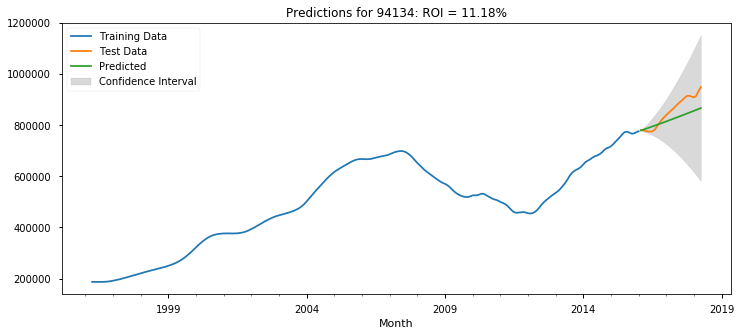

,Metric,Value
0,RMSE,43681.809876
1,R2,0.413999
2,Thiel's U,4.864026




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94132
[i] Starting Grid Search @ 01/11/2020 - 06:57:25 AM:


100%|██████████| 36/36 [00:04<00:00,  4.50it/s]


 Grid Search finished at 01/11/2020 - 06:57:30 AM
 Total time: 0:00:04.956735
Best Params {'order': (1, 2, 3, 12)}


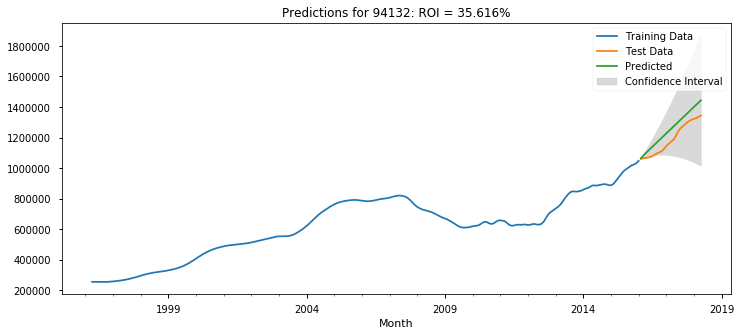

,Metric,Value
0,RMSE,70499.445212
1,R2,0.513460
2,Thiel's U,5.649823




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94124
[i] Starting Grid Search @ 01/11/2020 - 06:57:30 AM:


100%|██████████| 36/36 [00:05<00:00,  3.32it/s]


 Grid Search finished at 01/11/2020 - 06:57:35 AM
 Total time: 0:00:05.176151
Best Params {'order': (3, 3, 3, 12)}


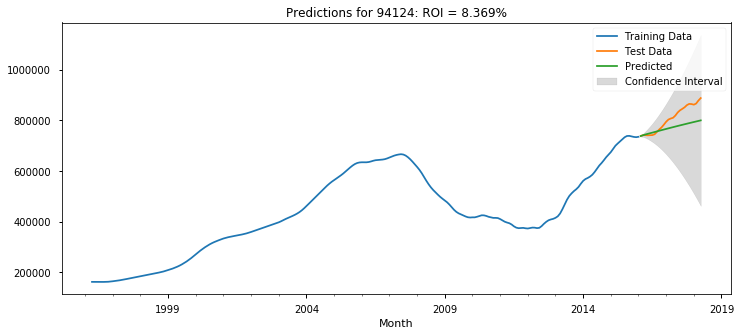

,Metric,Value
0,RMSE,48160.573576
1,R2,0.097941
2,Thiel's U,6.494789




------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Zipcode: 94127
[i] Starting Grid Search @ 01/11/2020 - 06:57:36 AM:


100%|██████████| 36/36 [00:05<00:00,  3.29it/s]


 Grid Search finished at 01/11/2020 - 06:57:41 AM
 Total time: 0:00:05.707728
Best Params {'order': (3, 3, 3, 12)}


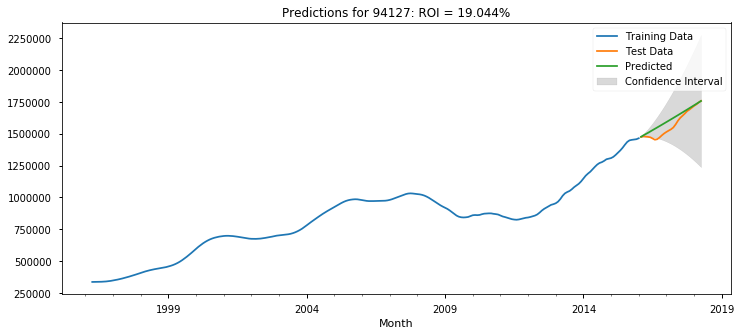

,Metric,Value
0,RMSE,53398.755293
1,R2,0.730304
2,Thiel's U,3.986146


In [174]:
params = opt_pdq_pdqm()

ts_resdict = {}
for zc,ts in ts_dict.items():
    print("\n")
    print('---'*30)
    print('---'*30)
    print(f'Zipcode: {zc}')
    
    # Train Test Split
    ts_train, ts_test = train_test_split_ts(ts, test_size=0.1)
    
    # Grid Search
    res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
    res.sort_values('AIC', inplace=True)
    best_params = dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc] = {}
    ts_resdict[zc]['res'] = res
    ts_resdict[zc]['best_params'] = best_params
    print('Best Params', best_params)
    
    model_output = SARIMAX(ts_train, **best_params, 
                          enforce_invertibility = False,
                          enforce_stationarity = False).fit()
    
    
    ts_resdict[zc]['model'] = model_output
    
    preds_df,fig,ax = get_model_preds_df(model_output, ts_train, ts_test)
    ts_resdict[zc]['preds_df'] = preds_df
    
    
    
    

# Forecast for the model



******************************************************************************************
******************************************************************************************
Zipcode 94109
[i] Starting Grid Search @ 01/11/2020 - 06:57:57 AM:


100%|██████████| 36/36 [00:07<00:00,  2.38it/s]


 Grid Search finished at 01/11/2020 - 06:58:05 AM
 Total time: 0:00:07.859955
Best Params {'order': (3, 2, 3, 12)}


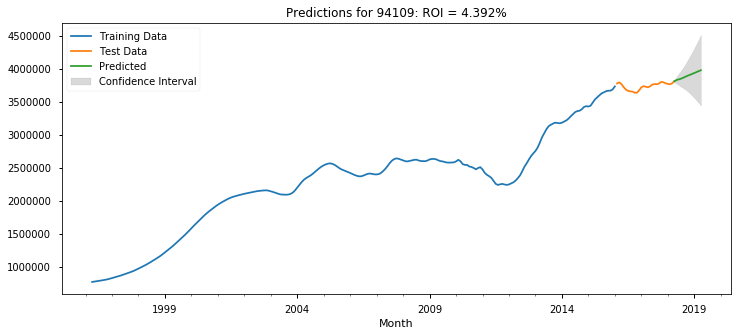



******************************************************************************************
******************************************************************************************
Zipcode 94110
[i] Starting Grid Search @ 01/11/2020 - 06:58:06 AM:


100%|██████████| 36/36 [00:07<00:00,  2.55it/s]


 Grid Search finished at 01/11/2020 - 06:58:14 AM
 Total time: 0:00:07.200731
Best Params {'order': (3, 3, 3, 12)}


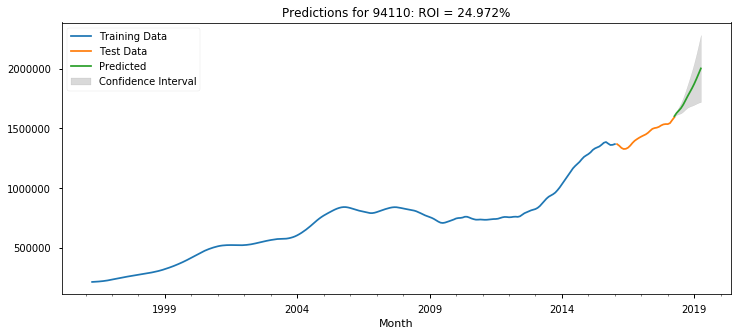



******************************************************************************************
******************************************************************************************
Zipcode 94122
[i] Starting Grid Search @ 01/11/2020 - 06:58:15 AM:


100%|██████████| 36/36 [00:06<00:00,  3.33it/s]


 Grid Search finished at 01/11/2020 - 06:58:21 AM
 Total time: 0:00:06.283186
Best Params {'order': (3, 1, 3, 12)}


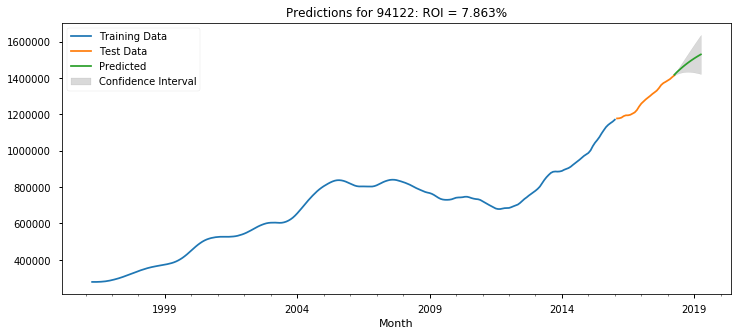



******************************************************************************************
******************************************************************************************
Zipcode 94112
[i] Starting Grid Search @ 01/11/2020 - 06:58:21 AM:


100%|██████████| 36/36 [00:05<00:00,  3.61it/s]


 Grid Search finished at 01/11/2020 - 06:58:27 AM
 Total time: 0:00:05.981999
Best Params {'order': (3, 2, 0, 12)}


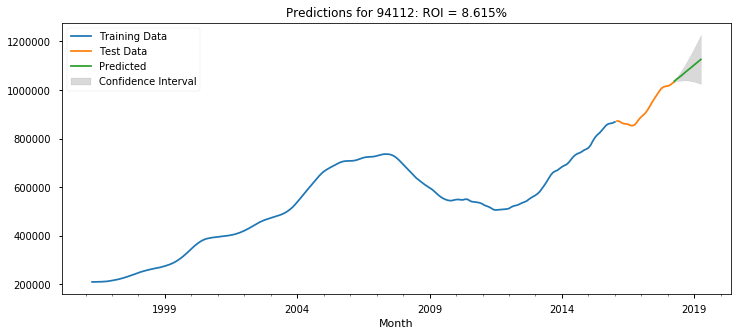



******************************************************************************************
******************************************************************************************
Zipcode 94115
[i] Starting Grid Search @ 01/11/2020 - 06:58:28 AM:


100%|██████████| 36/36 [00:06<00:00,  2.77it/s]


 Grid Search finished at 01/11/2020 - 06:58:35 AM
 Total time: 0:00:06.826734
Best Params {'order': (3, 2, 3, 12)}


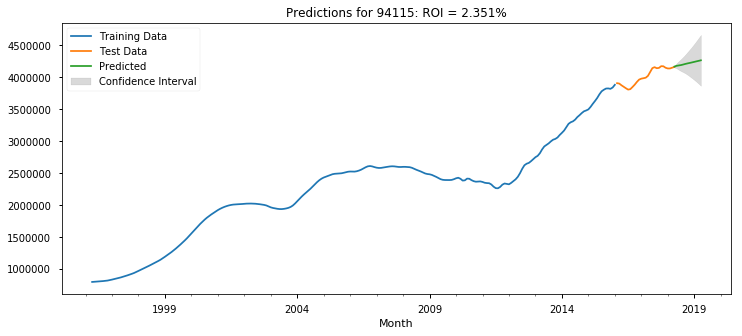



******************************************************************************************
******************************************************************************************
Zipcode 94117
[i] Starting Grid Search @ 01/11/2020 - 06:58:35 AM:


100%|██████████| 36/36 [00:06<00:00,  2.35it/s]


 Grid Search finished at 01/11/2020 - 06:58:42 AM
 Total time: 0:00:06.557453
Best Params {'order': (3, 2, 3, 12)}


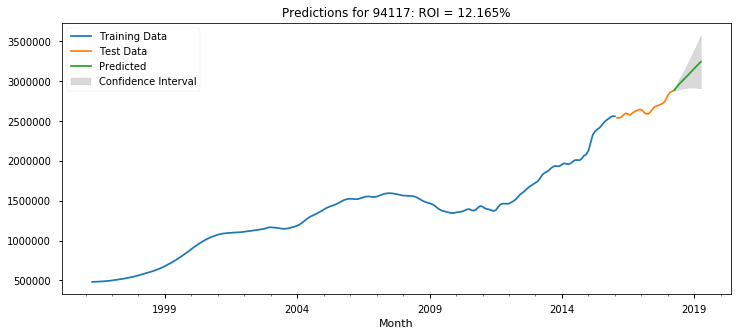



******************************************************************************************
******************************************************************************************
Zipcode 94121
[i] Starting Grid Search @ 01/11/2020 - 06:58:43 AM:


100%|██████████| 36/36 [00:06<00:00,  2.84it/s]


 Grid Search finished at 01/11/2020 - 06:58:49 AM
 Total time: 0:00:06.628265
Best Params {'order': (3, 3, 3, 12)}


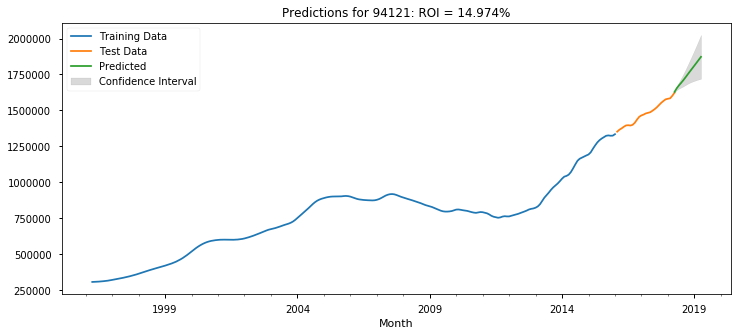



******************************************************************************************
******************************************************************************************
Zipcode 94118
[i] Starting Grid Search @ 01/11/2020 - 06:58:50 AM:


100%|██████████| 36/36 [00:08<00:00,  2.23it/s]


 Grid Search finished at 01/11/2020 - 06:58:59 AM
 Total time: 0:00:08.330716
Best Params {'order': (3, 1, 3, 12)}


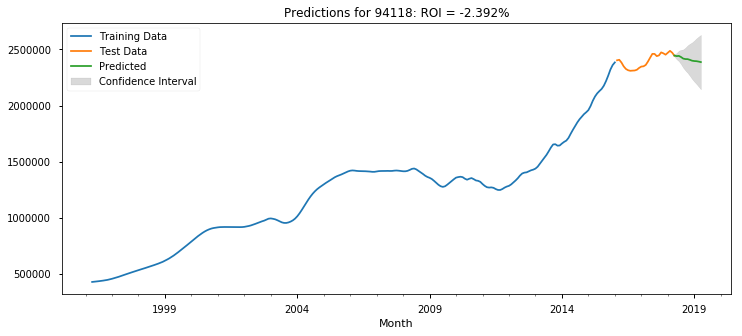



******************************************************************************************
******************************************************************************************
Zipcode 94114
[i] Starting Grid Search @ 01/11/2020 - 06:58:59 AM:


100%|██████████| 36/36 [00:08<00:00,  2.94it/s]


 Grid Search finished at 01/11/2020 - 06:59:08 AM
 Total time: 0:00:08.357636
Best Params {'order': (3, 2, 3, 12)}


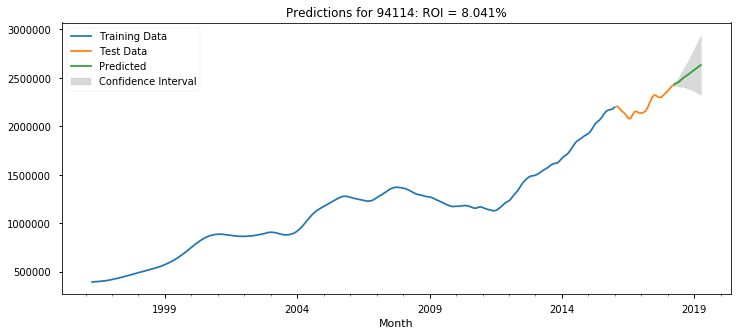



******************************************************************************************
******************************************************************************************
Zipcode 94103
[i] Starting Grid Search @ 01/11/2020 - 06:59:08 AM:


100%|██████████| 36/36 [00:07<00:00,  2.61it/s]


 Grid Search finished at 01/11/2020 - 06:59:15 AM
 Total time: 0:00:07.159839
Best Params {'order': (3, 3, 3, 12)}


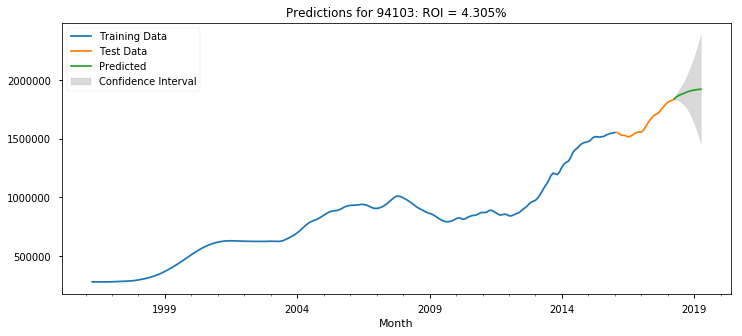



******************************************************************************************
******************************************************************************************
Zipcode 94107
[i] Starting Grid Search @ 01/11/2020 - 06:59:16 AM:


100%|██████████| 36/36 [00:04<00:00,  4.53it/s]


 Grid Search finished at 01/11/2020 - 06:59:21 AM
 Total time: 0:00:04.773228
Best Params {'order': (3, 2, 3, 12)}


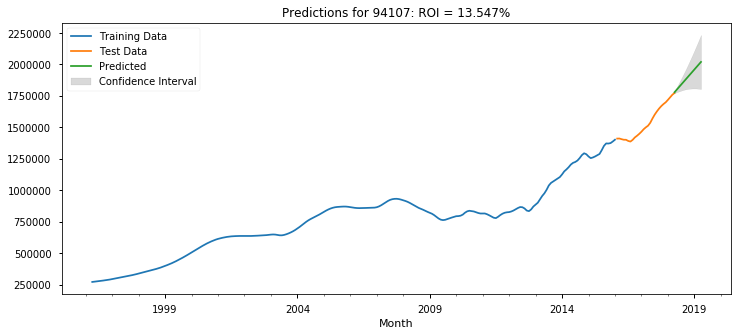



******************************************************************************************
******************************************************************************************
Zipcode 94116
[i] Starting Grid Search @ 01/11/2020 - 06:59:22 AM:


100%|██████████| 36/36 [00:04<00:00,  7.59it/s]


 Grid Search finished at 01/11/2020 - 06:59:27 AM
 Total time: 0:00:04.750290
Best Params {'order': (3, 2, 3, 12)}


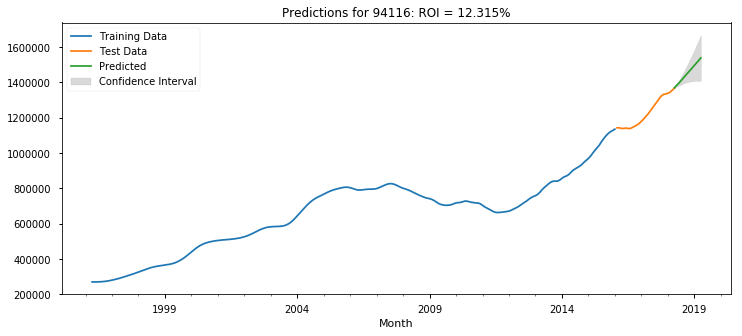



******************************************************************************************
******************************************************************************************
Zipcode 94123
[i] Starting Grid Search @ 01/11/2020 - 06:59:27 AM:


100%|██████████| 36/36 [00:05<00:00,  3.98it/s]


 Grid Search finished at 01/11/2020 - 06:59:32 AM
 Total time: 0:00:05.255936
Best Params {'order': (3, 2, 3, 12)}


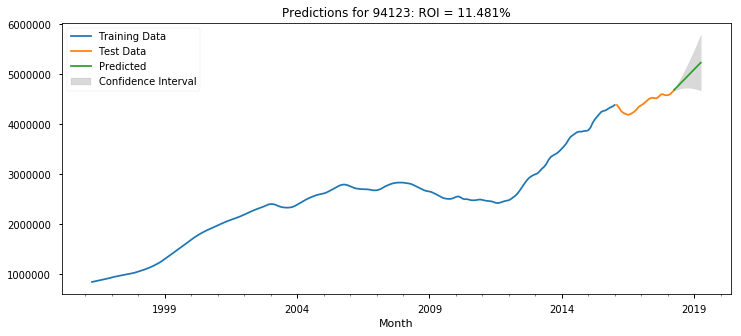



******************************************************************************************
******************************************************************************************
Zipcode 94131
[i] Starting Grid Search @ 01/11/2020 - 06:59:33 AM:


100%|██████████| 36/36 [00:05<00:00,  2.54it/s]


 Grid Search finished at 01/11/2020 - 06:59:39 AM
 Total time: 0:00:05.883257
Best Params {'order': (3, 2, 3, 12)}


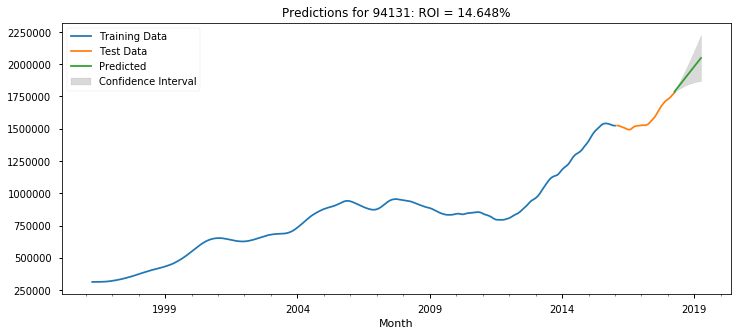



******************************************************************************************
******************************************************************************************
Zipcode 94133
[i] Starting Grid Search @ 01/11/2020 - 06:59:40 AM:


100%|██████████| 36/36 [00:09<00:00,  2.21it/s]


 Grid Search finished at 01/11/2020 - 06:59:50 AM
 Total time: 0:00:09.778938
Best Params {'order': (3, 1, 3, 12)}


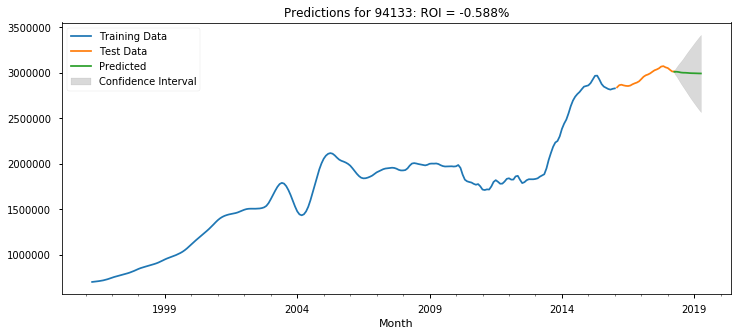



******************************************************************************************
******************************************************************************************
Zipcode 94134
[i] Starting Grid Search @ 01/11/2020 - 06:59:50 AM:


100%|██████████| 36/36 [00:06<00:00,  2.50it/s]


 Grid Search finished at 01/11/2020 - 06:59:57 AM
 Total time: 0:00:06.944419
Best Params {'order': (3, 3, 3, 12)}


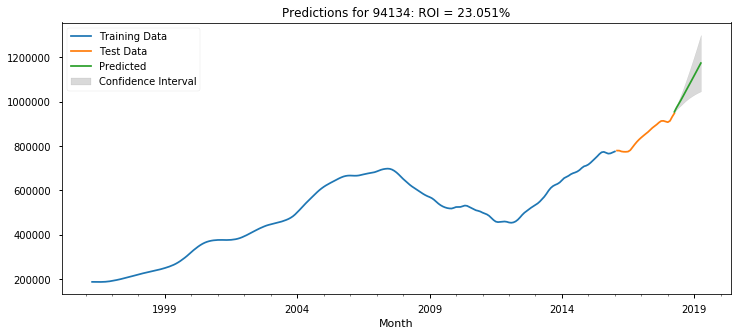



******************************************************************************************
******************************************************************************************
Zipcode 94132
[i] Starting Grid Search @ 01/11/2020 - 06:59:58 AM:


100%|██████████| 36/36 [00:06<00:00,  3.69it/s]


 Grid Search finished at 01/11/2020 - 07:00:04 AM
 Total time: 0:00:06.507587
Best Params {'order': (1, 2, 3, 12)}


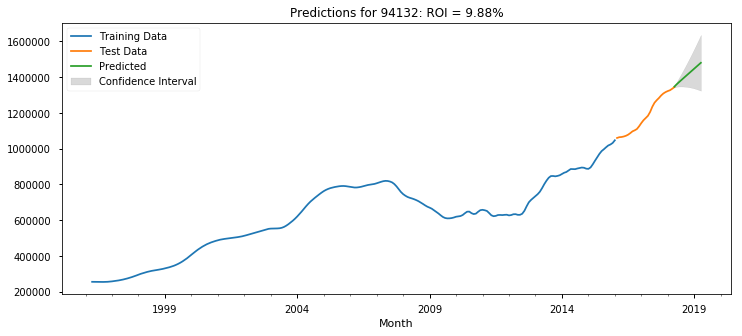



******************************************************************************************
******************************************************************************************
Zipcode 94124
[i] Starting Grid Search @ 01/11/2020 - 07:00:05 AM:


100%|██████████| 36/36 [00:06<00:00,  3.31it/s]


 Grid Search finished at 01/11/2020 - 07:00:12 AM
 Total time: 0:00:06.496616
Best Params {'order': (3, 3, 3, 12)}


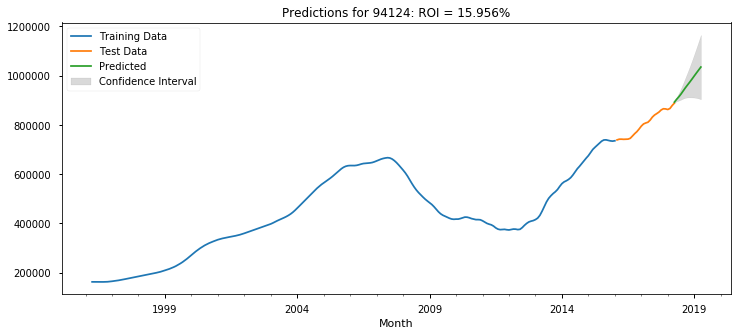



******************************************************************************************
******************************************************************************************
Zipcode 94127
[i] Starting Grid Search @ 01/11/2020 - 07:00:12 AM:


100%|██████████| 36/36 [00:07<00:00,  2.67it/s]


 Grid Search finished at 01/11/2020 - 07:00:20 AM
 Total time: 0:00:07.653521
Best Params {'order': (3, 3, 3, 12)}


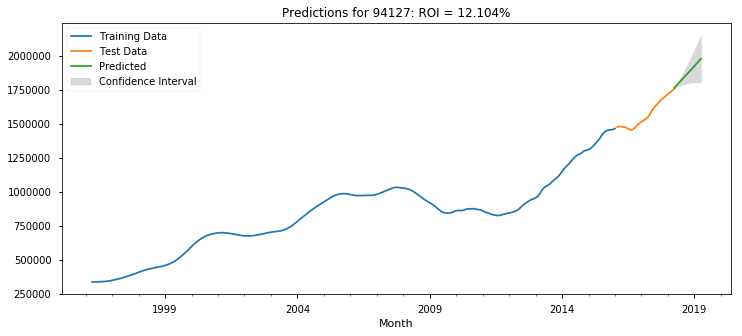

In [175]:
params = opt_pdq_pdqm()

ts_resdict = {}
for zc,ts in ts_dict.items():
    print('\n')
    print('***'*30)
    print('***'*30)
    print(f'Zipcode {zc}')
    
    ts_train, ts_test = train_test_split_ts(ts, test_size = 0.1)
    
    res = grid_search_arima(ts_train, order_dict = params, make_seasonal = False)
    res.sort_values('AIC', inplace = True)
    best_params = dict(order=res.iloc[0].loc['pdq'])
    
    ts_resdict[zc] = {}
    ts_resdict[zc]['res'] = res
    ts_resdict[zc]['best_params'] = best_params
    print('Best Params', best_params)
    
    model_output = SARIMAX(ts, **best_params, 
                          enforce_invertibility = False,
                          enforce_stationarity = False).fit()
    
    ts_resdict[zc]['model'] = model_output

    preds_df, fig, ax, = get_model_preds_df(model_output, ts_train, ts_test,
                                           start = ts.index[-1], 
                                           end = ts.index.shift(12)[-1], get_metrics = False)
    ts_resdict[zc]['preds_df'] = preds_df
    
    
